# Load Packages 

In [1]:
from querysquirrel import myfunctions

In [2]:
import sys
import torch
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoModel, AutoTokenizer 
import os
import pandas as pd
import dask.dataframe as dd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import string
import torch.nn.functional as F
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import re
import random
from torch.optim import AdamW

# Load Data

In [3]:
examples_path = os.path.join('.', 'data', 'shopping_queries_dataset_examples.parquet')
products_path = os.path.join('.', 'data', 'shopping_queries_dataset_products.parquet')
sources_path = os.path.join('.', 'data', 'shopping_queries_dataset_sources.csv')

examples = dd.read_parquet(examples_path)
products = dd.read_parquet(products_path)
sources = dd.read_csv(sources_path)

In [4]:
examples_products = dd.merge(
    examples,
    products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)

examples_products = examples_products[examples_products['product_locale'] == 'us']

task_2 = examples_products[examples_products['large_version'] == 1]

# removing puncuation 
# this takes in the dask data frame and the string puncuation 
# applied to the daskdata frame
# lambda which processes each test in the dask series 
# it iterates through each character and saves only characters that are not in puncts
puncts = string.punctuation

def process_text(text_series, puncts):
    return text_series.apply(lambda text: ''.join(ch for ch in str(text) if ch not in puncts))


task_2['query'] = task_2['query'].map_partitions(process_text, puncts=puncts)


# encoding the esci labels 
label_mapping = {'E': 0, 
                 'S': 1, 
                 'C': 2, 
                 'I': 3}

task_2['encoded_labels'] = task_2['esci_label'].map(label_mapping).astype(int)



task_2_train = task_2[task_2['split'] == 'train']
task_2_test = task_2[task_2['split'] == 'test']

/home/cgcordes/python3.14/lib/python3.11/site-packages/dask_expr/_collection.py:4196: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('esci_label', 'float64'))

  warnings.warn(meta_warning(meta))


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
import inspect 

In [7]:
# functions = {name: obj for name, obj in inspect.getmembers(myfunctions, inspect.isfunction)}
# print(functions.keys())  # Displays function names

In [8]:
# inspect.signature(myfunctions.process_partition)

# Defining Functions and Classes

In [9]:
def generate_embeddings(texts):
    batch_size = 128  # adjust this size
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def process_partition(partition):
    query_embeddings = generate_embeddings(partition['query'])
    product_title_embeddings = generate_embeddings(partition['product_title'])

    combined = torch.cat((torch.tensor(query_embeddings), torch.tensor(product_title_embeddings)), dim=1).numpy()
    
    print(f'Combined shape: {combined.shape}')  # Expecting (n, 1536)

    result = pd.DataFrame(combined, index=partition.index, columns=[f'embedding_{i}' for i in range(combined.shape[1])])

    return result

In [25]:
# Establishing the MLP Class 
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        # flatten the input 
        x = torch.flatten(x, 1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = x.unsqueeze(1)
        x = self.pool(x)  
        # flatten the pooled output 
        x = x.view(x.size(0), -1) 
        # apply the 10% dropout 
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [26]:
class ESCIDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings.values
        # this should be (size, 1563)
        print("Shape of embeddings:", self.embeddings.shape)
        self.labels = labels   

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [27]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
    model.train()  # set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(embeddings.float()) 
            # converting the labels to long 
            labels = labels.long()
            # calculate the loss 
            loss = criterion(outputs, labels) 
            # backpropogation 
            loss.backward() 
            # updating the weights 
            optimizer.step()  

            # add up the loss 
            epoch_loss += loss.item()  

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

In [28]:
def evaluate_model(test_loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # needed to change this to floats 
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # evaluate on the f1 score with micro averages
    return f1_score(all_labels, all_preds, average='micro')

In [29]:
def evaluate_and_capture_mismatches(test_loader, model, task_2_test):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # convert task_2_test to pandas df if it's a dask df
    if hasattr(task_2_test, 'compute'):
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']].compute()
    else:
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']]

    test_df['predicted_label'] = all_preds
    test_df['true_label'] = all_labels
    
    mismatch_df = test_df[test_df['true_label'] != test_df['predicted_label']]
    
    # added test to make the confusion matrix 
    return test_df, mismatch_df


# Model 1 - Distill Roberta

In [9]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
model = AutoModel.from_pretrained('distilroberta-base').to(device)

for param in model.parameters():
    param.requires_grad = False

In [10]:
# creating a data frame and enerate column names
meta = pd.DataFrame(columns=[f'embedding_{i}' for i in range(2 * 768)], dtype='float64')

### Computing the Embeddings 
####  Skip once read to CSV 

In [11]:
# Computing the Embeddings for Train Data 
result_train = task_2_train.map_partitions(process_partition, meta=meta)
result_train = result_train.compute()

Combined shape: (1393063, 1536)


In [42]:
# Read it to a CSV 
result_train.to_csv('result_train_distilroberta_nopunct.csv')

In [24]:
# Read it to a NUMPY 
result_array = result_train.to_numpy()
np.save('result_train_distilroberta.npy', result_array)

In [12]:
# Computing the Embeddings for the Test Data
result_test = task_2_test.map_partitions(process_partition, meta=meta)
result_test = result_test.compute()

Combined shape: (425762, 1536)


In [43]:
# Read it to a CSV 
result_test.to_csv('result_test_distilroberta_nopunct.csv')

In [19]:
# Read it to a NUMPY 
result_test_array = result_test.to_numpy()
np.save('result_test_distilroberta.npy', result2_array)

### Importing Embeddings  

In [17]:
# Read in the pre-saved data 
# This will take a little bit 
result_train = pd.read_csv('result_train_distilroberta_nopunct.csv', index_col=0)
result_test = pd.read_csv('result_test_distilroberta_nopunct.csv', index_col=0)

### Checking Structure 

In [13]:
# Converting from DASK to Pandas 
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [14]:
# this should all be the same: pandas.core.frame.DataFrame
print(type(task_2_train))
print(type(task_2_test))
print(type(result_train))
print(type(result_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Establishing Parameters for the Multi-Layer Preceptron Model

In [26]:
# Inputting the Parameters

# Size of the concatenated embeddings(768 + 768)
input_size = 1536  
hidden_size = 128
# number of classes Exact, Substitute, Complement, Irrelevant (4)
num_classes = 4 

# initialize the model, loss, and optimizer
model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# for the training hyperparameter configuration 
# Adam Optimizer with parameters: epsilon (1e-8), learning rate (5e-5) and weight decay (0.01)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)


### Data Loading 
#### Labeling Indicies

In [18]:
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

In [19]:
task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [47]:
# not needed if not sampling 
result_train = result_train.sort_index()
result_test = result_test.sort_index()

In [31]:
# checking the training labels 
print(subset_labels)

         encoded_labels
0                     3
1                     0
2                     0
3                     0
4                     0
...                 ...
1818820               3
1818821               0
1818822               0
1818823               3
1818824               0

[1393063 rows x 1 columns]


In [32]:
# checking the test labels 
print(subset_labels2)

         encoded_labels
32                    3
33                    3
34                    0
35                    1
36                    1
...                 ...
1818788               0
1818789               3
1818790               3
1818791               3
1818792               0

[425762 rows x 1 columns]


In [20]:
# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # adjust the batch size as needed 

Shape of embeddings: (1393063, 1536)


In [21]:
# making the test loader 
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (425762, 1536)


In [22]:
# these should be the same length 
print("Length of embeddings:", len(train_dataset.embeddings))
print("Length of labels:", len(train_dataset.labels))

Length of embeddings: 1393063
Length of labels: 1393063


In [23]:
# these should both be 'numpy.ndarray' or theres a problem 
print("Type of embeddings:", type(train_dataset.embeddings))
print("Type of labels:", type(train_dataset.labels))

Type of embeddings: <class 'numpy.ndarray'>
Type of labels: <class 'numpy.ndarray'>


In [24]:
# training loop
train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.8373
Epoch 2/4, Loss: 0.8152
Epoch 3/4, Loss: 0.8076
Epoch 4/4, Loss: 0.8026


In [26]:
# evaluating the model
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.6568


### Finding Mismatches for Distill Roberta

In [31]:
# getting the mismatches of the labels 
test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_26405/955037894.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_26405/955037894.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


In [32]:
# count top 10 mismatches per query
mismatch_counts_per_query = mismatch_df['query'].value_counts().head(10) 
mismatch_counts_per_product = mismatch_df['product_title'].value_counts().head(10)

all_text = ' '.join(mismatch_df['query'].tolist() + mismatch_df['product_title'].tolist())
word_counts = Counter(all_text.split()).most_common(10)  # Top 10 common words

print("Top 10 queries with the most mismatches:\n", mismatch_counts_per_query)
print("\nTop 10 most common words in mismatched entries:\n", word_counts)

Top 10 queries with the most mismatches:
 query
fitbit charge 3                            63
apple earbuds                              60
firestick                                  56
airpods 2                                  53
futon frames full size without mattress    48
dek pro                                    48
kindle                                     46
marvel against humanity game               42
keep grinding hat                          42
shaggy dog board game                      41
Name: count, dtype: int64

Top 10 most common words in mismatched entries:
 [('for', 65883), ('-', 44162), ('with', 39187), ('and', 37141), ('&', 18883), ('of', 14617), ('|', 11607), ('Black', 11581), ('without', 10492), ('2', 9482)]


### Confusion Matrix

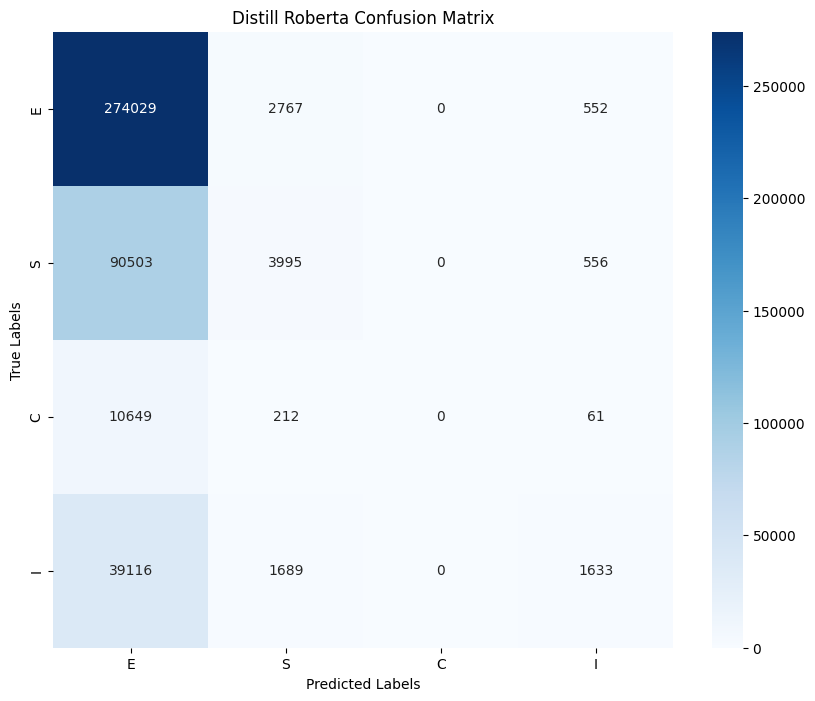

In [33]:
# make the confusion matrix
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Distill Roberta Confusion Matrix')
plt.show()


# Model 2 - alldistilroberta-v1 

In [37]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-distilroberta-v1')
model = AutoModel.from_pretrained('sentence-transformers/all-distilroberta-v1').to(device)

for param in model.parameters():
    param.requires_grad = False

In [38]:
# creating a data frame and enerate column names
meta = pd.DataFrame(columns=[f'embedding_{i}' for i in range(2 * 768)], dtype='float64')

### Creating Embeding 
#### Ignore if Reading Embeddings in
#### Reload data if continuing from above 

In [14]:
# Computing the Embeddings for Train Data 
result_train = task_2_train.map_partitions(process_partition, meta=meta)
result_train = result_train.compute()

Combined shape: (1393063, 1536)


In [18]:
# Read it to a CSV 
result_train.to_csv('result_train_all-distilroberta-v1_nopunct.csv')

In [18]:
# Read it to a NUMPY 
result_array = result_train.to_numpy()
np.save('result_train_all-distilroberta-v1.npy', result_array)

In [15]:
# Computing the Embeddings for the Test Data
result_test = task_2_test.map_partitions(process_partition, meta=meta)
result_test = result_test.compute()

Combined shape: (425762, 1536)


In [23]:
# Read it to a CSV 
result_test.to_csv('result_test_all-distilroberta-v1_nopunct.csv')

In [21]:
# Read it to a NUMPY 
result2_array = result_test.to_numpy()
np.save('result_test_all-distilroberta-v1.npy', result2_array)

### Reading in the all-distilroberta Data

In [15]:
# read in the train and test 
result_train = pd.read_csv('balanced_train.csv', index_col=0)
result_test = pd.read_csv('result_test_all-distilroberta-v1_nopunct.csv', index_col=0)

### Converting from DASK to pandas 

In [16]:
# Converting from DASK to Pandas 
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [18]:
# this should all be the same: pandas.core.frame.DataFrame
print(type(task_2_train))
print(type(task_2_test))
print(type(result_train))
print(type(result_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Re-establishing the MLP

In [30]:
# Inputting the Parameters

# Size of the concatenated embeddings(768 + 768)
input_size = 1536  
hidden_size = 128
# number of classes Exact, Substitute, Complement, Irrelevant (4)
num_classes = 4 

# initialize the model, loss, and optimizer
model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# for the training hyperparameter configuration 
# Adam Optimizer with parameters: epsilon (1e-8), learning rate (5e-5) and weight decay (0.01)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)

### Labeling Indicies and Data loading

In [41]:
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

In [42]:
task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [43]:
# not needed if not sampling 
result_train = result_train.sort_index()
result_test = result_test.sort_index()

In [34]:
# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # adjust the batch size as needed 

Shape of embeddings: (116508, 1536)


In [45]:
# making the test loader 
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (425762, 1536)


### Training and Testing for all-distillroberta v1

In [29]:
# training loop
train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.8047
Epoch 2/4, Loss: 0.7897
Epoch 3/4, Loss: 0.7850
Epoch 4/4, Loss: 0.7831


In [31]:
# evaluating the model
# ran it earlier and got 0.6577
# now have 0.6562
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.6584


### Detecting and Looking at Mismatches

In [28]:
# getting the mismatches
test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_26405/955037894.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_26405/955037894.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


In [29]:
# count top 10 mismatches per query
mismatch_counts_per_query = mismatch_df['query'].value_counts().head(10) 
mismatch_counts_per_product = mismatch_df['product_title'].value_counts().head(10)

all_text = ' '.join(mismatch_df['query'].tolist() + mismatch_df['product_title'].tolist())
word_counts = Counter(all_text.split()).most_common(10)  # Top 10 common words

print("Top 10 queries with the most mismatches:\n", mismatch_counts_per_query)
print("\nTop 10 most common words in mismatched entries:\n", word_counts)

Top 10 queries with the most mismatches:
 query
fitbit charge 3                            63
apple earbuds                              60
firestick                                  56
airpods 2                                  53
futon frames full size without mattress    48
dek pro                                    48
kindle                                     46
marvel against humanity game               42
keep grinding hat                          42
shaggy dog board game                      41
Name: count, dtype: int64

Top 10 most common words in mismatched entries:
 [('for', 65883), ('-', 44162), ('with', 39187), ('and', 37141), ('&', 18883), ('of', 14617), ('|', 11607), ('Black', 11581), ('without', 10492), ('2', 9482)]


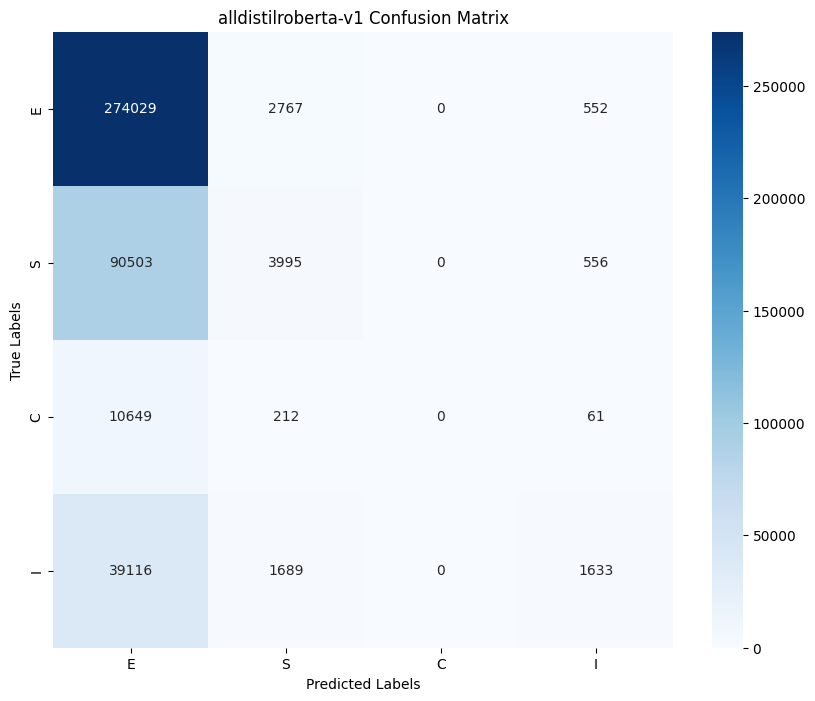

In [30]:
# make the confusion matrix
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('alldistilroberta-v1 Confusion Matrix')
plt.show()


# Data Augmentation Methods 

## 1X synomyn replacement 

In [24]:
# Computing the Embeddings for Train Data 
result_train = combined_df.map_partitions(process_partition, meta=meta)
result_train = result_train.compute()

Combined shape: (1422190, 1536)


In [38]:
# Reading the embeddings to a csv
result_train.to_csv('result_train_distilroberta_nopunct_synreplacement.csv')

In [30]:
# Computing the Embeddings for the Test Data
result_test = pd.read_csv('result_test_all-distilroberta-v1_nopunct.csv', index_col=0)

In [25]:
task_2_train = combined_df.compute()
task_2_test = task_2_test.compute()

In [26]:
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

In [27]:
task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [28]:
# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # adjust the batch size as needed 

Shape of embeddings: (1422190, 1536)


In [31]:
# making the test loader 
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (425762, 1536)


In [34]:
# training loop
train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.7921
Epoch 2/4, Loss: 0.7287
Epoch 3/4, Loss: 0.7001
Epoch 4/4, Loss: 0.6814


In [35]:
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.6679


In [36]:
test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_121502/955037894.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_121502/955037894.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


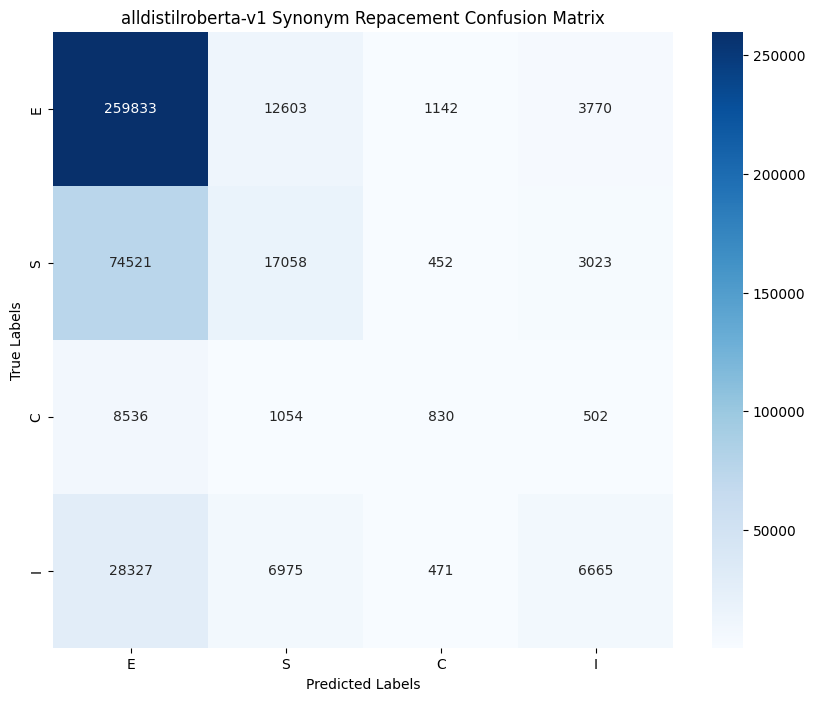

In [37]:
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('alldistilroberta-v1 Synonym Repacement Confusion Matrix')
plt.show()

## 2X

In [10]:
# Subset of the C Class Labels 
task_2_train_C = task_2_train[task_2_train['encoded_labels'] == 2]

In [11]:
# define the stopwords to only be in english
stop_words = set(stopwords.words('english'))

In [12]:
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            if word != l.name():
                synonyms.append(l.name())
    return synonyms

def replace_with_synonyms(text, seed, stop_words, regex_pattern):
    random.seed(seed)
    words = text.split()
    modified_text = text

    for word in words:
        # this checks if the word (converted to lowercase) is in stop_words or matches the regex pattern 
        if (stop_words and word.lower() in stop_words) or (regex_pattern and regex_pattern.match(word)):
            continue
        synonyms = get_synonyms(word)
        
        if synonyms:
            synonym = random.choice(synonyms)
            modified_text = re.sub(r'\b' + re.escape(word) + r'\b', synonym, modified_text)

    return modified_text

def augment_product_titles(df, seed, stop_words, regex_pattern):
    random.seed(seed)
    augmented_rows = []
    
    for _, row in df.iterrows():
        original_title = row['product_title']
        augmented_title = replace_with_synonyms(original_title, seed, stop_words, regex_pattern)  
        
        augmented_row = row.copy()
        augmented_row['product_title'] = augmented_title
        augmented_rows.append(augmented_row)

    return pd.DataFrame(augmented_rows)

def multiply_augmentation(df, times, SEEDS, stop_words, regex_pattern):
    augmented_dfs = []
    
    for seed in SEEDS[:times]:
        augmented_df = augment_product_titles(df, seed=seed, stop_words=stop_words, regex_pattern=regex_pattern)
        augmented_dfs.append(augmented_df)

    augmented_df_combined = pd.concat(augmented_dfs, ignore_index=True)
    
    return augmented_df_combined

In [13]:
# a regex pattern to ignore any combonation of 2 letter words to deal with abbreviations 
stopwords_regex = re.compile(r'\b[A-Za-z]{2}\b')
SEEDS = [43, 190, 492, 799, 1111, 1432, 3927, 5689, 6001, 6102, 
         6203, 6304, 6405, 6506, 6607, 6708, 6809, 6910, 7011, 7112, 
         7213, 7314, 7415, 7516, 7617, 7718, 7819, 7920, 8021, 8122, 
         8223, 8324, 8425, 8526, 8627, 8728, 8829, 8930, 9031, 9132, 
         9233, 9334, 9435, 9436, 9437, 9438, 9439, 9440, 9441, 9442]
# numbers = [str(i) for i in range(1, 11)]
# adding 100 numbers to the stopwords so they dont get altered either
# stop_words.update(numbers)

In [ ]:
augmented_df = multiply_augmentation(task_2_train_C, 2, SEEDS, stop_words=stop_words, regex_pattern=stopwords_regex)

In [20]:
indices = [2, 29129]
for idx in indices:
    print(f"Row {idx}: {augmented_df['product_title'].iloc[idx]}")

Row 2: Molton brown jasmine & sun arise bathroom & lavish Gel, 10 Fl Oz
Row 29129: Molton brownness jasmine & insolate climb tub & cascade Gel, 10 Fl Oz


In [16]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-distilroberta-v1')
model = AutoModel.from_pretrained('sentence-transformers/all-distilroberta-v1').to(device)

for param in model.parameters():
    param.requires_grad = False

In [17]:
meta = pd.DataFrame(columns=[f'embedding_{i}' for i in range(2 * 768)], dtype='float64')

In [23]:
augmented_df = dd.from_pandas(augmented_df, npartitions=1)
print(augmented_df.npartitions)

1


In [24]:
# Computing the embeddings for the augmented data 
result_train_augmented = augmented_df.map_partitions(process_partition, meta=meta)
result_train_augmented = result_train_augmented.compute()

Combined shape: (58254, 1536)


In [25]:
# Reading in the embeddings for the Train and Test Data
# This will take a little bit 
result_train = pd.read_csv('result_train_all-distilroberta-v1_nopunct.csv', index_col=0)
result_test = pd.read_csv('result_test_all-distilroberta-v1_nopunct.csv', index_col=0)

In [26]:
# this should all be the same: pandas.core.frame.DataFrame
print(type(augmented_df))
print(type(result_train_augmented))
print(type(task_2_train))
print(type(task_2_test))
print(type(result_train))
print(type(result_test))

<class 'dask_expr._collection.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'dask_expr._collection.DataFrame'>
<class 'dask_expr._collection.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [27]:
augmented_df = augmented_df.compute()
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [29]:
# now we need to combine and ensure we're getting the right labels 
# I need to combine and reindex for the train dataset 
task_2_train = pd.concat([task_2_train, augmented_df], ignore_index=True)
task_2_train = task_2_train.reset_index(drop=True)
# I need to combine and reindex for the train embeddings dataset as well 
result_train = pd.concat([result_train, result_train_augmented], ignore_index=True)
result_train = result_train.reset_index(drop=True)

In [ ]:
# now read in the mlp and parameters

In [36]:
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

In [37]:
task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [38]:
# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # adjust the batch size as needed 

Shape of embeddings: (1451317, 1536)


In [39]:
# making the test loader 
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (425762, 1536)


In [40]:
# training loop
train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.7897
Epoch 2/4, Loss: 0.7215
Epoch 3/4, Loss: 0.6929
Epoch 4/4, Loss: 0.6744


In [41]:
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.6667


In [42]:
test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_152071/955037894.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_152071/955037894.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


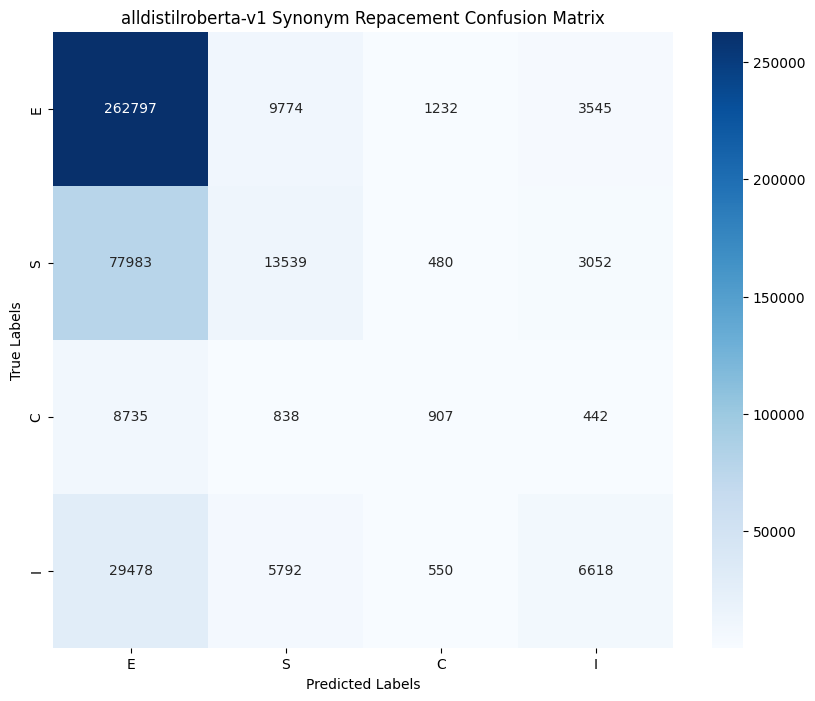

In [44]:
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('alldistilroberta-v1 Synonym Repacement Confusion Matrix')
plt.show()

## 50X the C-Class 

In [14]:
augmented_df_50 = multiply_augmentation(task_2_train_C, 50, SEEDS, stop_words=stop_words, regex_pattern=stopwords_regex)

In [62]:
# reitterating the model 
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-distilroberta-v1')
model = AutoModel.from_pretrained('sentence-transformers/all-distilroberta-v1').to(device)

for param in model.parameters():
    param.requires_grad = False

In [63]:
meta = pd.DataFrame(columns=[f'embedding_{i}' for i in range(2 * 768)], dtype='float64')

In [17]:
augmented_df_50 = dd.from_pandas(augmented_df_50, npartitions=1)

In [18]:
# Computing the embeddings for the augmented data 
result_train_augmented = augmented_df_50.map_partitions(process_partition, meta=meta)
result_train_augmented = result_train_augmented.compute()

Combined shape: (1456350, 1536)


In [19]:
# Reading in the embeddings for the Train and Test Data
# This will take a little bit 
result_train = pd.read_csv('result_train_all-distilroberta-v1_nopunct.csv', index_col=0)
result_test = pd.read_csv('result_test_all-distilroberta-v1_nopunct.csv', index_col=0)

In [22]:
# this should all be the same: pandas.core.frame.DataFrame
print(type(augmented_df_50))
print(type(result_train_augmented))
print(type(task_2_train))
print(type(task_2_test))
print(type(result_train))
print(type(result_test))

<class 'dask_expr._collection.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [21]:
augmented_df = augmented_df_50.compute()
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [23]:
# now we need to combine and ensure we're getting the right labels 
# I need to combine and reindex for the train dataset 
task_2_train = pd.concat([task_2_train, augmented_df], ignore_index=True)
task_2_train = task_2_train.reset_index(drop=True)
# I need to combine and reindex for the train embeddings dataset as well 
result_train = pd.concat([result_train, result_train_augmented], ignore_index=True)
result_train = result_train.reset_index(drop=True)

In [24]:
# encoding the labels 
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()
task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [35]:
# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (2849413, 1536)
Shape of embeddings: (425762, 1536)


In [33]:
# training loop
train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.4622
Epoch 2/4, Loss: 0.3956
Epoch 3/4, Loss: 0.3770
Epoch 4/4, Loss: 0.3657


In [36]:
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.6535


In [38]:
test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_177314/955037894.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_177314/955037894.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


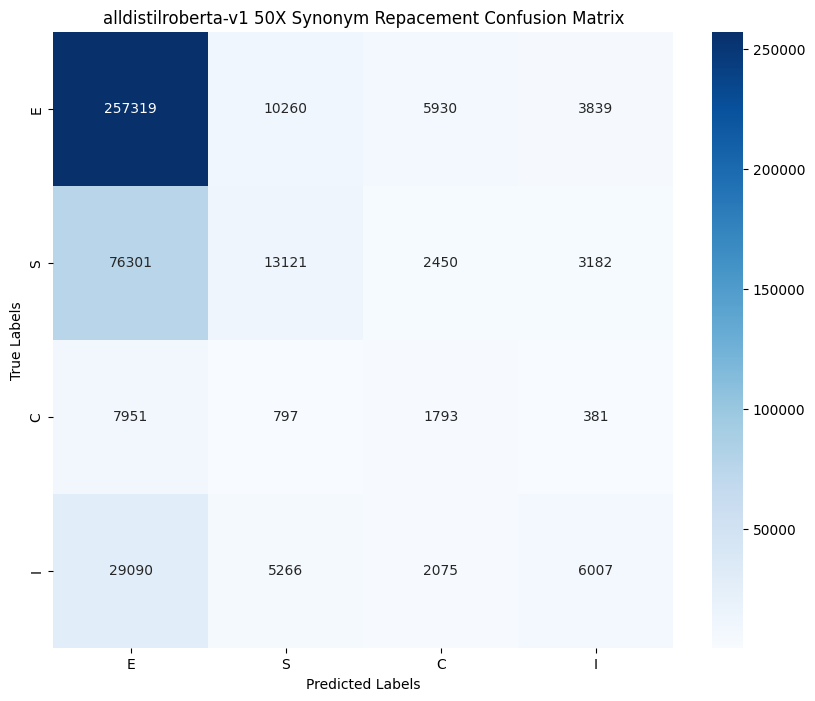

In [40]:
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('alldistilroberta-v1 50X Synonym Repacement Confusion Matrix')
plt.show()

## 5x the C-Class 

In [16]:
augmented_df_5 = multiply_augmentation(task_2_train_C, 5, SEEDS, stop_words=stop_words, regex_pattern=stopwords_regex)

In [17]:
augmented_df_5 = dd.from_pandas(augmented_df_5, npartitions=1)

In [18]:
# Computing the embeddings for the augmented data 
result_train_augmented_5 = augmented_df_5.map_partitions(process_partition, meta=meta)
result_train_augmented_5 = result_train_augmented_5.compute()

Combined shape: (145635, 1536)


In [19]:
# Reading in the embeddings for the Train and Test Data
# This will take a little bit 
result_train = pd.read_csv('result_train_all-distilroberta-v1_nopunct.csv', index_col=0)
result_test = pd.read_csv('result_test_all-distilroberta-v1_nopunct.csv', index_col=0)

In [20]:
augmented_df_5 = augmented_df_5.compute()
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [21]:
# now we need to combine and ensure we're getting the right labels 
# I need to combine and reindex for the train dataset 
task_2_train = pd.concat([task_2_train, augmented_df_5], ignore_index=True)
task_2_train = task_2_train.reset_index(drop=True)
# I need to combine and reindex for the train embeddings dataset as well 
result_train = pd.concat([result_train, result_train_augmented_5], ignore_index=True)
result_train = result_train.reset_index(drop=True)

In [22]:
# encoding the labels 
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()
task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [30]:
# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (1538698, 1536)
Shape of embeddings: (425762, 1536)


In [31]:
# training loop
train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.7663
Epoch 2/4, Loss: 0.6943
Epoch 3/4, Loss: 0.6654
Epoch 4/4, Loss: 0.6468


In [32]:
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.6653


In [33]:
test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_191378/955037894.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_191378/955037894.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


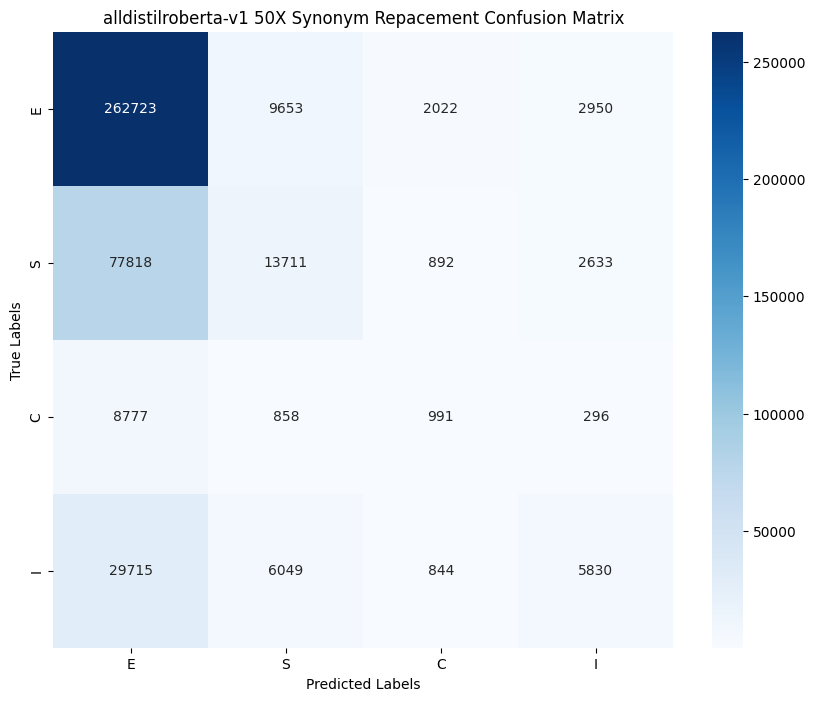

In [34]:
# this title is meant to be only a 5X 
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('alldistilroberta-v1 5X Synonym Repacement Confusion Matrix')
plt.show()

## 4X the C-Class

In [14]:
augmented_df_4 = multiply_augmentation(task_2_train_C, 4, SEEDS, stop_words=stop_words, regex_pattern=stopwords_regex)

In [15]:
augmented_df_4 = dd.from_pandas(augmented_df_4, npartitions=1)

In [18]:
# Computing the embeddings for the augmented data 
result_train_augmented_4 = augmented_df_4.map_partitions(process_partition, meta=meta)
result_train_augmented_4 = result_train_augmented_4.compute()

Combined shape: (116508, 1536)


In [19]:
# Reading in the embeddings for the Train and Test Data
# This will take a little bit 
result_train = pd.read_csv('result_train_all-distilroberta-v1_nopunct.csv', index_col=0)
result_test = pd.read_csv('result_test_all-distilroberta-v1_nopunct.csv', index_col=0)

In [20]:
# this should all be the same: pandas.core.frame.DataFrame
print(type(augmented_df_4))
print(type(result_train_augmented_4))
print(type(task_2_train))
print(type(task_2_test))
print(type(result_train))
print(type(result_test))

<class 'dask_expr._collection.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'dask_expr._collection.DataFrame'>
<class 'dask_expr._collection.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [21]:
augmented_df_4 = augmented_df_4.compute()
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [22]:
# now we need to combine and ensure we're getting the right labels 
# combine and reindex for the train dataset 
task_2_train = pd.concat([task_2_train, augmented_df_4], ignore_index=True)
task_2_train = task_2_train.reset_index(drop=True)
# combine and reindex for the train embeddings dataset as well 
result_train = pd.concat([result_train, result_train_augmented_4], ignore_index=True)
result_train = result_train.reset_index(drop=True)

In [23]:
# encoding the labels 
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [31]:
# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (1509571, 1536)
Shape of embeddings: (425762, 1536)


In [32]:
# training loop
train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.7742
Epoch 2/4, Loss: 0.7036
Epoch 3/4, Loss: 0.6756
Epoch 4/4, Loss: 0.6568


In [33]:
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.6641


In [34]:
test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_199254/955037894.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_199254/955037894.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


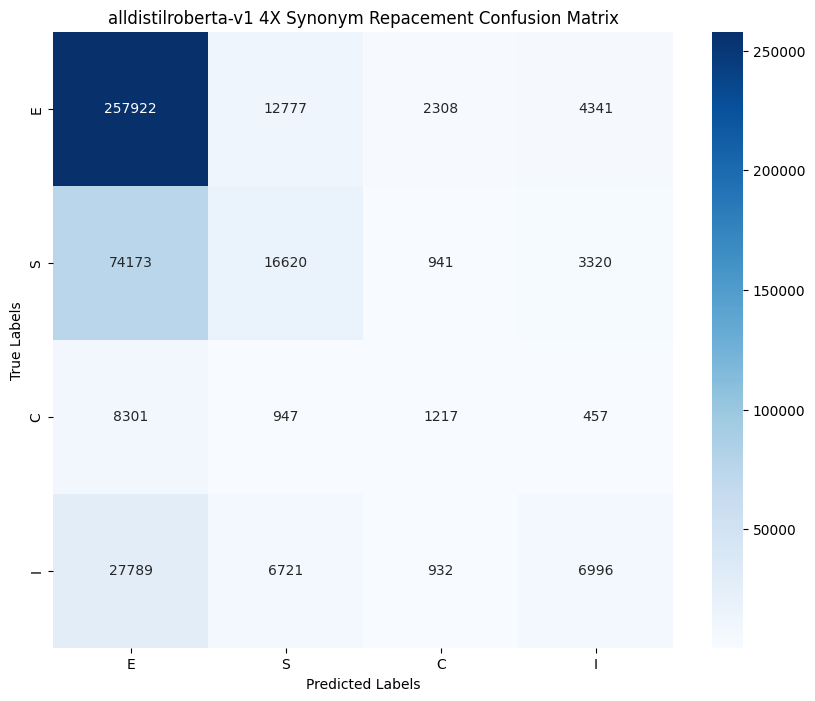

In [35]:
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('alldistilroberta-v1 4X Synonym Repacement Confusion Matrix')
plt.show()